### Apple Leaf Health Analyzer
by Marsh [ @vbookshelf ]<br>
12 March 2020

<img src="http://apple.test.woza.work/assets/kaggleimage.jpg" width="500"></img>


## Introduction

In this kernel we will build a Tensorflow_2.0 Keras model to classify the health status of apple tree leaves. 

There are 4 output classes:
- healthy
- multiple_diseases
- rust
- scab


The dataset consists of 1821 training images. This is quite small by deep learning standards. However, by using data augmentation combined with a pre-trained Mobilenet model the validation accuracy score will be greater than 90%. Augmentation will also help the model to generalize better.

I chose Mobilenet because my aim was to deploy the trained model online in a Tensorflow.js web interface. The web app makes it possible for this model to be taken outside and field tested under varying image conditions - lighting, shade, angles, depth, orienation etc. 

Mobilenet was designed for use on the web. It's small which means that it downoads fairly quickly and it runs fast. 

This is the link to the live web app. I suggest using the Chrome browser. The code is available on Github. 

> Web App<br>
> http://apple.test.woza.work/
>
> Github<br>
> https://github.com/vbookshelf/Apple-Tree-Leaf-Health-Analyzer




## Data Summary

- 1821 jpg train images
- 1821 jpg test images
- 4 classes: healthy (516 images), multiple_diseases (91 images), rust (622 images), scab (592 images)
- There are substantially fewer images in the multiple_diseases class.





## Approach

- Resize all images to 224x224x3
- Use a 80/20 train test split
- Fine tune a Mobilenet model that was pre-trained on imagenet.
- Use the Adam optimizer, categorical crossentropy loss and a learning rate of 0.001 with reduce-on-plateau.
- We won't use the pre-processing method that was applied to the imagenet images that were used to pre-train Mobilenet. Instead we will simply normalize all images by dividing by 255.
- Perform image augmentation using the Albumentations library. Data augmentation will help to reduce overfitting, improve model performance and help the model generalize better.
- Upsample the data in the multiple_diseases class as recommended in this paper:<br>
A systematic study of the class imbalance problem in convolutional neural networks<br>https://arxiv.org/abs/1710.05381

In [1]:
# Check the tensorflow version

import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import pandas as pd
import numpy as np
import os

import cv2

import albumentations as albu
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensor


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report

import shutil

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3


In [4]:
os.listdir('../input/plant-pathology-2020-fgvc7')

['images', 'train.csv', 'test.csv', 'sample_submission.csv']

## Helper Functions

In [5]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




## Prepare the Data

### Create dataframes

In [6]:
path = '../input/plant-pathology-2020-fgvc7/train.csv'
df_train = pd.read_csv(path)

path = '../input/plant-pathology-2020-fgvc7/test.csv'
df_test = pd.read_csv(path)

path = '../input/plant-pathology-2020-fgvc7/sample_submission.csv'
df_sample = pd.read_csv(path)


print(df_train.shape)
print(df_test.shape)
print(df_sample.shape)

(1821, 5)
(1821, 1)
(1821, 5)


In [7]:
# Identify the target class of each row in the train set

def get_class(row):
    
    if row['multiple_diseases'] == 1:
        return 'multiple_diseases'
    
    elif row['rust'] == 1:
        return 'rust'
    
    elif row['scab'] == 1:
        return 'scab'
    
    else:
        return 'healthy'
    
df_train['target'] = df_train.apply(get_class, axis=1)

df_train.head()

image_id  healthy  multiple_diseases  rust  scab             target
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy

## Display some images from each class

In [8]:
# Filter out each class
df_healthy = df_train[df_train['target'] == 'healthy']
df_multiple_diseases = df_train[df_train['target'] == 'multiple_diseases']
df_rust = df_train[df_train['target'] == 'rust']
df_scab = df_train[df_train['target'] == 'scab']


In [9]:
# Example
df_scab.head()

image_id  healthy  multiple_diseases  rust  scab target
0    Train_0        0                  0     0     1   scab
7    Train_7        0                  0     0     1   scab
8    Train_8        0                  0     0     1   scab
11  Train_11        0                  0     0     1   scab
12  Train_12        0                  0     0     1   scab

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


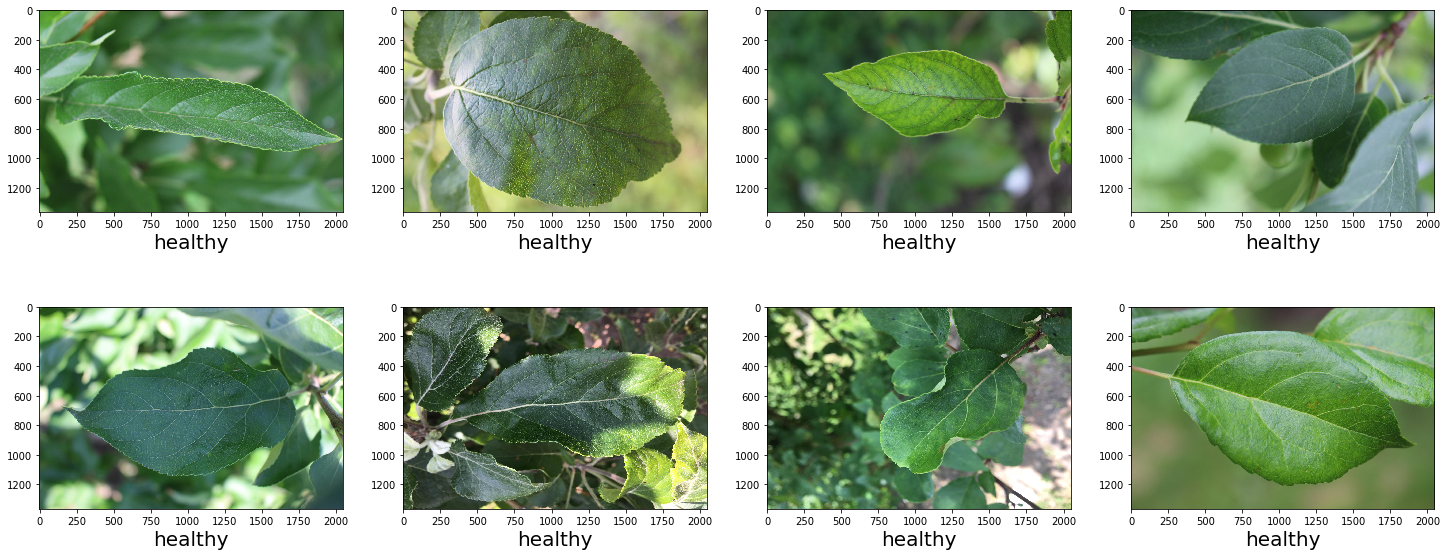

In [10]:
path = '../input/plant-pathology-2020-fgvc7/images/'

image_list = list(df_healthy['image_id'])


# set up the canvas for the subplots
plt.figure(figsize=(25,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get an image
    image = image_list[i]
    
    # display the image
    plt.imshow(plt.imread(path + image + '.jpg'))
    
    plt.xlabel('healthy', fontsize=20)

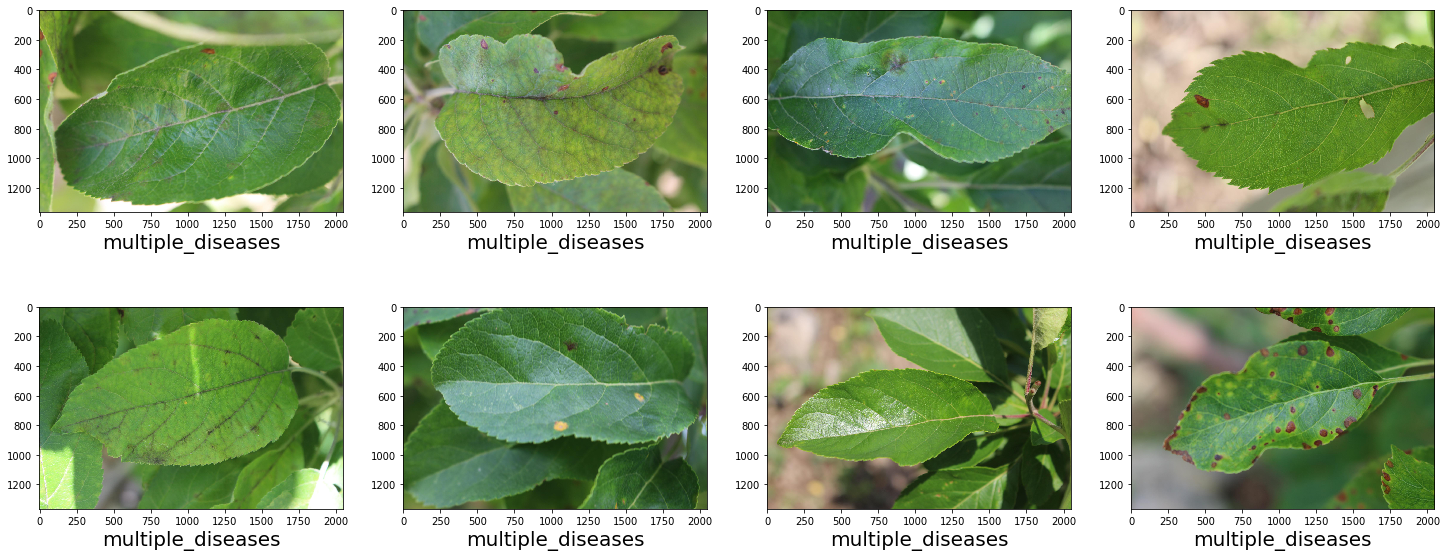

In [11]:
path = '../input/plant-pathology-2020-fgvc7/images/'

image_list = list(df_multiple_diseases['image_id'])


# set up the canvas for the subplots
plt.figure(figsize=(25,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get an image
    image = image_list[i]
    
    # display the image
    plt.imshow(plt.imread(path + image + '.jpg'))
    
    plt.xlabel('multiple_diseases', fontsize=20)

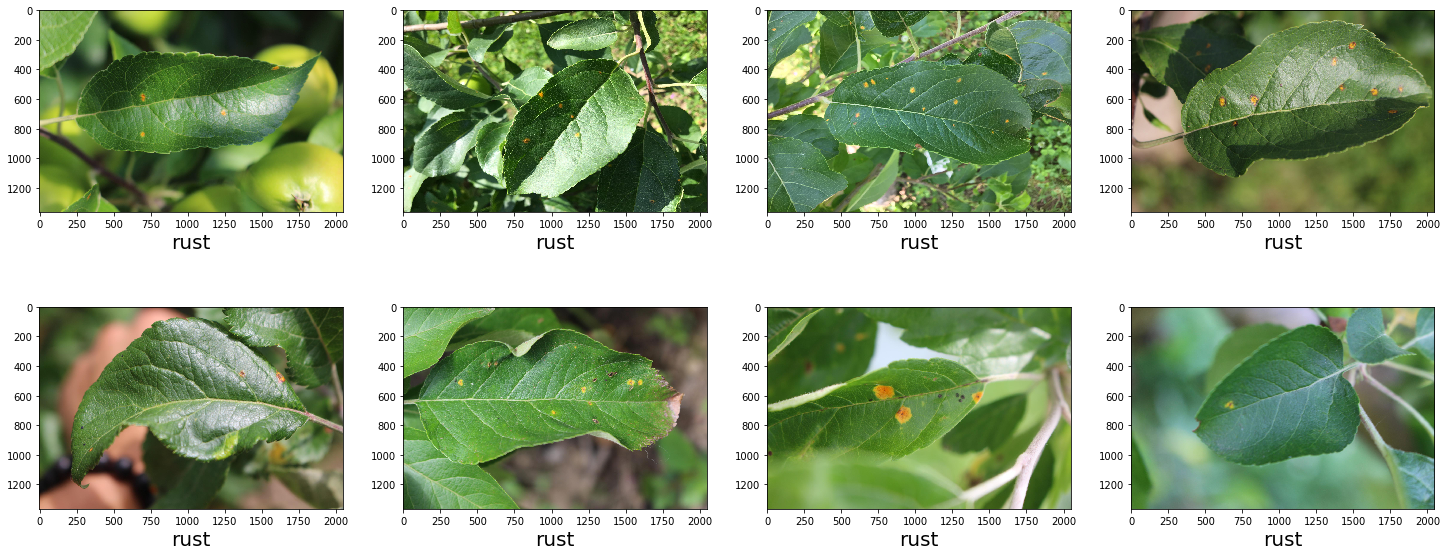

In [12]:
path = '../input/plant-pathology-2020-fgvc7/images/'

image_list = list(df_rust['image_id'])


# set up the canvas for the subplots
plt.figure(figsize=(25,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get an image
    image = image_list[i]
    
    # display the image
    plt.imshow(plt.imread(path + image + '.jpg'))
    
    plt.xlabel('rust', fontsize=20)

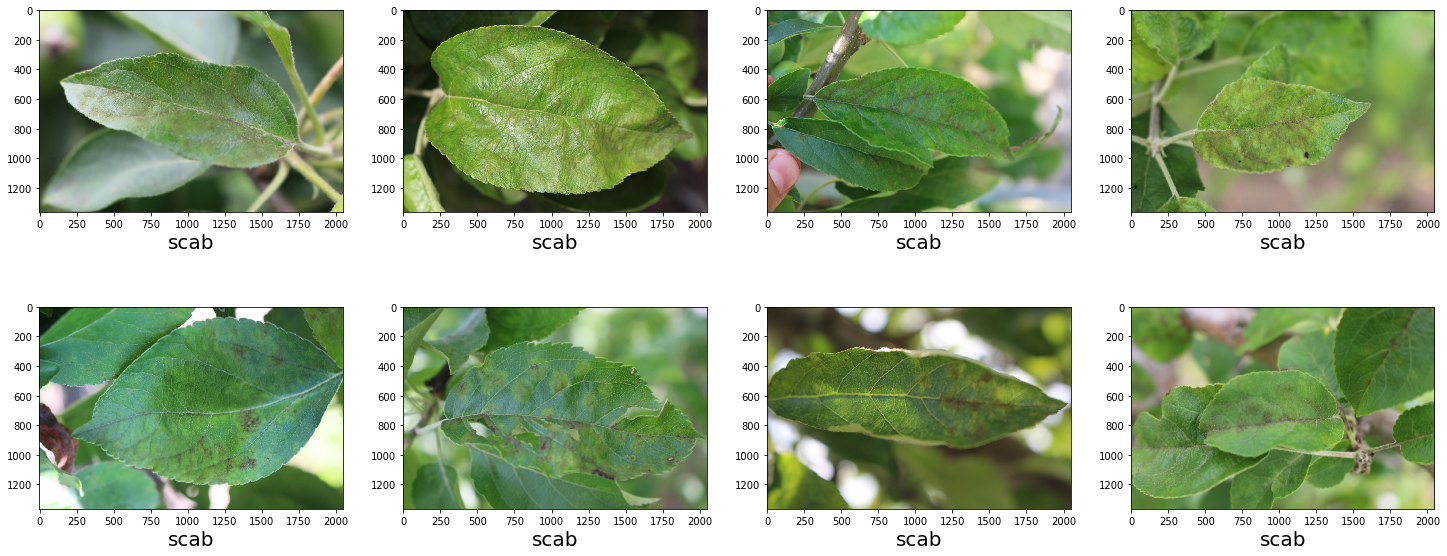

In [13]:
path = '../input/plant-pathology-2020-fgvc7/images/'

image_list = list(df_scab['image_id'])


# set up the canvas for the subplots
plt.figure(figsize=(25,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get an image
    image = image_list[i]
    
    # display the image
    plt.imshow(plt.imread(path + image + '.jpg'))
    
    plt.xlabel('scab', fontsize=20)

## Create the train and val sets

In [14]:
df_train['target'].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: target, dtype: int64

In [15]:
# select the column that we will use for stratification
y = df_train['target']

# shuffle
df_train = shuffle(df_train)

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=101, stratify=y)


print(df_train.shape)
print(df_val.shape)

(1456, 6)
(365, 6)


In [16]:
df_train['target'].value_counts()

rust                 484
scab                 472
healthy              424
multiple_diseases     76
Name: target, dtype: int64

In [17]:
df_val['target'].value_counts()

rust                 138
scab                 120
healthy               92
multiple_diseases     15
Name: target, dtype: int64

## Upsample the multiple_diseases class

In [18]:
df_1 = df_train[df_train['target'] != 'multiple_diseases']

df_2 = df_train[df_train['target'] == 'multiple_diseases']

df_train_up = pd.concat([df_1, df_2,  df_2,  df_2,  df_2,  df_2], axis=0).reset_index(drop=True)

df_train = shuffle(df_train_up)

print(df_train.shape)

df_train.head()

(1760, 6)


image_id  healthy  multiple_diseases  rust  scab             target
207   Train_1259        0                  0     0     1               scab
27    Train_1714        0                  0     1     0               rust
805    Train_577        0                  0     1     0               rust
994    Train_847        0                  0     1     0               rust
1663  Train_1390        0                  1     0     0  multiple_diseases

In [19]:
# This is the new class distribution of the train set

df_train['target'].value_counts()

rust                 484
scab                 472
healthy              424
multiple_diseases    380
Name: target, dtype: int64

## Save the dataframes as compressed csv files
These csv files will allow us to use Pandas chunking to feed images into the generators.

In [20]:
df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)
df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)

In [21]:
!ls

__notebook__.ipynb  df_test.csv.gz  df_train.csv.gz  df_val.csv.gz


## Set up and test the Augmentations

In [22]:
# Albumentations

import albumentations as albu


def augment_image(augmentation, image):
    
    """
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    
    return image_matrix



In [23]:
# Define the transforms

# Modified from --> Pneumothorax - 1st place solution
# Source: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/107824#latest-620521


aug_types = albu.Compose([
            albu.HorizontalFlip(),
             albu.OneOf([
                albu.HorizontalFlip(),
                albu.VerticalFlip(),
                ], p=0.8),
            albu.OneOf([
                albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness(),
                ], p=0.3),
            albu.OneOf([
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                albu.GridDistortion(),
                albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                ], p=0.3),
            albu.ShiftScaleRotate()
            ])



Test_1412.jpg


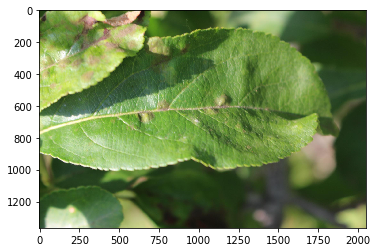

In [24]:
# Get an image to test the transformations

# get a list of train png images
path = '../input/plant-pathology-2020-fgvc7/images/'
image_list = os.listdir(path)

fname = image_list[1]
image_path = path + fname

print(fname)

image = plt.imread(image_path)
plt.imshow(image)

plt.show()

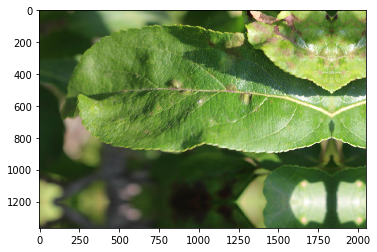

In [25]:
# Test the transformation setup.
# The image will be different each time this cell is run.

aug_image = augment_image(aug_types, image)

plt.imshow(aug_image)

plt.show()

## Build the Data Generators

### [ 1 ] Train Generator

In [26]:
#df_train.head()

In [27]:
def train_generator(batch_size=8):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image_id'])
            
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i] + '.jpg'


                # set the path to the image
                path = '../input/plant-pathology-2020-fgvc7/images/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create y_train
            # ===============
                cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
                y_train = df[cols]
                y_train = np.asarray(y_train) 


       
              
            # Augment the image and mask
            # ===========================

                aug_image = augment_image(aug_types, image)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                          
                
            # Normalize the images
            X_train = X_train/255

            yield X_train, y_train

In [28]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=8)

# run the generator
X_train, y_train = next(train_gen)

print(X_train.shape)
print(y_train.shape)

(8, 224, 224, 3)
(8, 4)


In [29]:
y_train

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]])

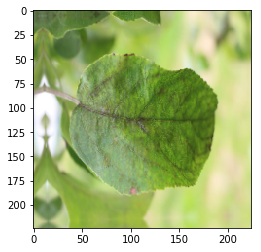

In [30]:
# Print the first image in X_train
# Remember that train images have been augmented.

image = X_train[0,:,:,:]
plt.imshow(image)

### [ 2 ] Val Generator

In [31]:
def val_generator(batch_size=5):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image_id'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_val
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i] + '.jpg'


                # set the path to the image
                path = '../input/plant-pathology-2020-fgvc7/images/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_val[i] = image
                
                
            
            
            # Create y_val
            # ===============

                cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
                y_val = df[cols]
                y_val = np.asarray(y_val) 

                       
                
            # Normalize the images
            X_val = X_val/255

            yield X_val, y_val

In [32]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=5)

# run the generator
X_val, y_val = next(val_gen)

print(X_val.shape)
print(y_val.shape)

(5, 224, 224, 3)
(5, 4)


In [33]:
y_val

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])

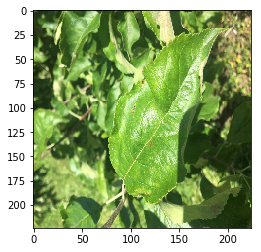

In [34]:
# print the image from X_val
image = X_val[0,:,:,:]
plt.imshow(image)

### [ 3 ] Test Generator

In [35]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image_id'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            

        
            
            # Create X_test
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i] + '.jpg'


                # set the path to the image
                path = '../input/plant-pathology-2020-fgvc7/images/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

                # insert the image into X_train
                X_test[i] = image
                
                 
                
            # Normalize the images
            X_test = X_test/255

            yield X_test

In [36]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=1)

# run the generator
X_test = next(test_gen)

print(X_test.shape)

(1, 224, 224, 3)


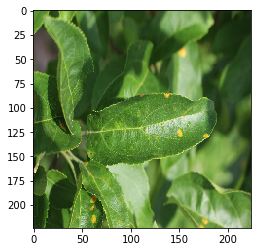

In [37]:
# print the image from X_test

image = X_test[0,:,:,:]
plt.imshow(image)

## Model Architecture

In [38]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


In [39]:
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(4, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
______________________________________________________________

## Train the Model

In [40]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 5

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = TRAIN_BATCH_SIZE
val_batch_size = VAL_BATCH_SIZE

# determine num train steps
train_steps = np.ceil(num_train_samples / train_batch_size)

# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [41]:
# Initialize the generators
train_gen = train_generator(batch_size=TRAIN_BATCH_SIZE)
val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

model.compile(
    Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])



filepath = "model.h5"

#earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=3, 
                                   verbose=1, mode='max')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, csv_logger, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=50, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

Train for 220.0 steps, validate for 73.0 steps
Epoch 1/50
219/220 [============================>.] - ETA: 0s - loss: 2.6224 - accuracy: 0.6027
Epoch 00001: val_accuracy improved from -inf to 0.70137, saving model to model.h5
220/220 [==============================] - 98s 444ms/step - loss: 2.6140 - accuracy: 0.6028 - val_loss: 2.4641 - val_accuracy: 0.7014
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.7533 - accuracy: 0.7454
Epoch 00002: val_accuracy improved from 0.70137 to 0.87123, saving model to model.h5
220/220 [==============================] - 85s 385ms/step - loss: 0.7566 - accuracy: 0.7449 - val_loss: 0.4689 - val_accuracy: 0.8712
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.5497 - accuracy: 0.8248
Epoch 00003: val_accuracy did not improve from 0.87123
220/220 [==============================] - 83s 378ms/step - loss: 0.5513 - accuracy: 0.8239 - val_loss: 0.4098 - val_accuracy: 0.8521
Epoch 4/50
219/220 [=====================

In [42]:
# Display the training log

train_log = pd.read_csv('training_log.csv')

train_log.head()

epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.602841  2.614024      0.701370  2.464122
1      1  0.744886  0.756638      0.871233  0.468944
2      2  0.823864  0.551325      0.852055  0.409774
3      3  0.822727  0.496678      0.917808  0.240452
4      4  0.858523  0.395194      0.909589  0.238235

## Evaluate the model on the val set

In [43]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [44]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=VAL_BATCH_SIZE)

val_loss, val_acc = \
model.evaluate_generator(val_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.1747570474748101
val_acc: 0.96712327


## Plot the training curves

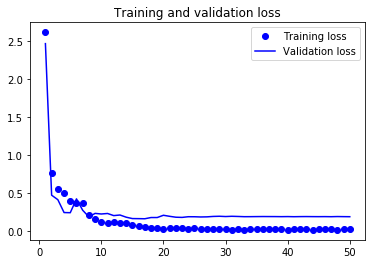

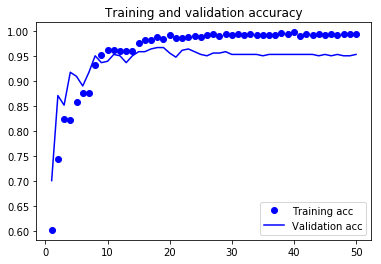

<Figure size 432x288 with 0 Axes>

In [45]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()

## Make a prediction on the val set

In [46]:
model.load_weights('model.h5')

val_gen = val_generator(batch_size=1)

preds = model.predict_generator(val_gen, steps=len(df_val), verbose=1)


365/365 [==============================] - 15s 42ms/step


In [47]:
# get y_pred as index values

y_pred = np.argmax(preds, axis=1)


In [48]:
# get y_true as index values

cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_true = df_val[cols]
y_true = np.asarray(y_true) 

y_true = np.argmax(y_true, axis=1)


## Confusion Matrix

In [49]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[ 90   1   0   1]
 [  0   9   1   5]
 [  1   1 136   0]
 [  2   0   0 118]]


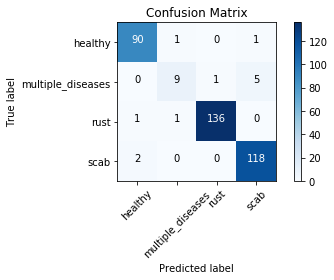

In [50]:
cm_plot_labels = ['healthy', 'multiple_diseases', 'rust', 'scab']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Classification Report

In [51]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['healthy', 'multiple_diseases', 'rust', 'scab'])

print(report)

                   precision    recall  f1-score   support

          healthy       0.97      0.98      0.97        92
multiple_diseases       0.82      0.60      0.69        15
             rust       0.99      0.99      0.99       138
             scab       0.95      0.98      0.97       120

         accuracy                           0.97       365
        macro avg       0.93      0.89      0.91       365
     weighted avg       0.97      0.97      0.97       365



**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

This is a helpful tutorial by Minsuk Heo on Accuracy, Precision and F1 Score:<br>
https://www.youtube.com/watch?v=HBi-P5j0Kec

## Make a test set prediction

In [52]:
model.load_weights('model.h5')

# initialize the generator
test_gen = test_generator(batch_size=1)

preds = model.predict_generator(test_gen, steps=len(df_test), verbose=1)

1821/1821 [==============================] - 76s 42ms/step


In [53]:
#preds

In [54]:
# Put the preds into a dataframe

df_preds = pd.DataFrame(preds, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])

df_preds['image_id'] = df_test['image_id'].copy()

df_preds.head()

healthy  multiple_diseases      rust          scab image_id
0  1.264777e-07       1.142043e-03  0.998858  1.133898e-07   Test_0
1  8.902699e-06       1.529117e-02  0.984698  1.520012e-06   Test_1
2  7.354429e-08       8.982989e-07  0.000004  9.999951e-01   Test_2
3  9.999086e-01       3.316864e-07  0.000065  2.564438e-05   Test_3
4  2.551227e-06       4.761789e-02  0.952367  1.210118e-05   Test_4

In [55]:
df_test.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

## Create a submission csv file

In [56]:
#df_sample.head()

In [57]:
# Create a submission csv file

df_results = pd.DataFrame({'image_id': df_preds.image_id,
                            'healthy': df_preds.healthy,
                               'multiple_diseases': df_preds.multiple_diseases,
                               'rust': df_preds.rust,
                               'scab': df_preds.scab
                           }).set_index('image_id')


# create a submission csv file
df_results.to_csv('submission.csv', 
                  columns=['healthy', 'multiple_diseases', 'rust', 'scab']) 

In [58]:
df_results.head()

healthy  multiple_diseases      rust          scab
image_id                                                         
Test_0    1.264777e-07       1.142043e-03  0.998858  1.133898e-07
Test_1    8.902699e-06       1.529117e-02  0.984698  1.520012e-06
Test_2    7.354429e-08       8.982989e-07  0.000004  9.999951e-01
Test_3    9.999086e-01       3.316864e-07  0.000065  2.564438e-05
Test_4    2.551227e-06       4.761789e-02  0.952367  1.210118e-05

In [59]:
!ls

__notebook__.ipynb  df_train.csv.gz  model.h5	     training_log.csv
df_test.csv.gz	    df_val.csv.gz    submission.csv


## Convert the Model to Tensorflow.js

This needs to be done so that the model can be used in the web app.

In [60]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

     |████████████████████████████████| 57 kB 2.0 MB/s 
     |████████████████████████████████| 89 kB 4.4 MB/s 
     |████████████████████████████████| 20.1 MB 6.9 MB/s 
     |████████████████████████████████| 2.9 MB 39.5 MB/s 
     |████████████████████████████████| 104.6 MB 73 kB/s 
     |████████████████████████████████| 248 kB 46.6 MB/s 
     |████████████████████████████████| 914 kB 42.9 MB/s 
     |████████████████████████████████| 690 kB 54.4 MB/s 
     |████████████████████████████████| 1.3 MB 46.0 MB/s 
     |████████████████████████████████| 448 kB 46.4 MB/s 
     |████████████████████████████████| 104 kB 60.4 MB/s 
     |████████████████████████████████| 2.7 MB 30.1 MB/s 
     |████████████████████████████████| 26.1 MB 6.8 kB/s 
     |████████████████████████████████| 41 kB 657 kB/s 
     |████████████████████████████████| 57 kB 4.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 3.8 MB 41.5 MB/s 
     |██████████████████

In [61]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs/model

In [62]:
# check that the folder containing the tfjs model files has been created
!ls

__notebook__.ipynb  df_train.csv.gz  model.h5	     tfjs
df_test.csv.gz	    df_val.csv.gz    submission.csv  training_log.csv


## Citations

- Albumentations: fast and flexible image augmentations<br>
https://arxiv.org/abs/1809.06839

- Plant Pathology 2020 - FGVC7 Dataset<br>
Paper pending

- Image by congerdesign on Pixabay

## Conclusion

Overall it appears that deep learning can handle this classification task quite easily. The only area that the model struggles with is classifying the multiple_diseases class. If the researchers were to add more raw image data to this class then that should fix this weakness. 


One of the research objectives of this competition is to determine if a model is able to perform well when the images vary in depth perception—angle, light and shade. This is quite easy to test by accessing the web app on a mobile phone. 

With a phone the leaves can be photograhed at different angles, depths and under different lighting conditions. The app will instantly classify each photograph so it will be easy to judge this model's capability under different conditions. 

- Navigate to http://apple.test.woza.work/
- Click the Submit button and then select "Camera". (This works on Android.)
- Take a photo of a leaf. The photo you take will be sent directly to the app for classification.




As a bonus here are a few things that you can do to improve the leaderboard score:
- Use a larger pre-trained model.
- Use test time augmentation (TTA).
- Try pseudo labeling.
- Ensemble the predictions from different folds and/or different models - stack the predictions or take a simple average.


Thank you for reading.